# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)

## Подготовка данных

In [1]:
#импортируем необходимые библиотеки и инструменты
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [2]:
car_data = pd.read_csv('/datasets/autos.csv')

In [3]:
car_data.info()
car_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


При первом взгляде на датасет заметно, что в нем есть пропуски, а также много ненужных столбцов, например:
- DateCrawled — дата скачивания анкеты из базы
- RegistrationMonth — месяц регистрации автомобиля
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Избавимся от них и перейдем к обратке пропусков.

In [4]:
cars_data = car_data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis='columns')

In [5]:
cars_data.info()
cars_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


Пропуски есть в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`. Пропуски в vehicle_type, gearbox, fuel_type заполним, исходя из бренда и модели автомобиля. Остальные NaN-ы заменим нетипичным значением `unk` - модель воспримет их как отдельную категорию.

In [6]:
cars_data['Name'] = cars_data['Brand'] + ' ' + cars_data['Model']
# заполняем пропуски в Gearbox
names_gb = [name for name in list(cars_data[cars_data['Gearbox'].isna()]['Name'].unique()) if isinstance(name, str) == True]

for name in names_gb:
    cars_data.loc[(cars_data['Name']==name)&(cars_data['Gearbox'].isna()), 'Gearbox'] = cars_data[cars_data['Name']==name]['Gearbox'].value_counts().index[0]

In [7]:
# заполняем пропуски в VehicleType
names_vt = [name for name in list(cars_data[cars_data['VehicleType'].isna()]['Name'].unique()) if isinstance(name, str) == True]

for name in names_vt:
    cars_data.loc[(cars_data['Name']==name)&(cars_data['VehicleType'].isna()), 'VehicleType'] = cars_data[cars_data['Name']==name]['VehicleType'].value_counts().index[0]

In [8]:
# заполняем пропуски в FuelType
names_ft = [name for name in list(cars_data[cars_data['FuelType'].isna()]['Name'].unique()) if isinstance(name, str) == True]

for name in names_ft:
    cars_data.loc[(cars_data['Name']==name)&(cars_data['FuelType'].isna()), 'FuelType'] = cars_data[cars_data['Name']==name]['FuelType'].value_counts().index[0]

In [9]:
cars_data.fillna(value='unk', inplace=True)
cars_data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,Name
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,unk,volkswagen golf
1,18300,coupe,2011,manual,190,unk,125000,gasoline,audi,yes,unk
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,unk,jeep grand
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,volkswagen golf
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,skoda fabia


Посмотрим теперь на дубликаты в данных, удалим их:


In [10]:
cars_data[cars_data.duplicated()==True]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,Name
1117,950,small,1999,manual,60,polo,150000,petrol,volkswagen,no,volkswagen polo
1396,0,unk,2000,unk,0,unk,150000,unk,volvo,unk,unk
2169,0,coupe,2002,manual,129,c_klasse,150000,petrol,mercedes_benz,no,mercedes_benz c_klasse
2833,1499,small,2001,manual,58,corsa,150000,petrol,opel,no,opel corsa
3025,2800,wagon,2005,manual,0,touran,150000,gasoline,volkswagen,no,volkswagen touran
...,...,...,...,...,...,...,...,...,...,...,...
354352,6500,sedan,2003,auto,145,e_klasse,150000,gasoline,mercedes_benz,no,mercedes_benz e_klasse
354355,4400,sedan,2008,manual,105,leon,150000,gasoline,seat,no,seat leon
354358,1490,small,1998,manual,50,lupo,150000,petrol,volkswagen,no,volkswagen lupo
354359,7900,sedan,2010,manual,140,golf,150000,gasoline,volkswagen,no,volkswagen golf


In [11]:
cars_data.drop_duplicates(inplace=True)

Проверим датасет на наличие выбросов.

<AxesSubplot:>

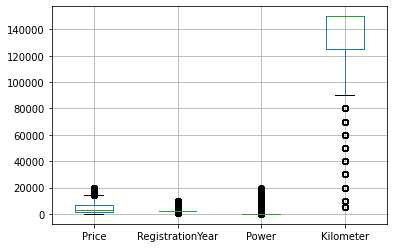

In [12]:
cars_data.boxplot()

 Год регистрации не может быть меньше 1931, когда был зарегистрирован первый автомобиль:

In [13]:
cars_data = cars_data.query('RegistrationYear <= 2022 and RegistrationYear >= 1931')

 Самая маленькая из существующих мощность автомобиля 4 л.с, на втором месте 8 л.с. Примем 8 л.с за отметку корректных цифр. В данных машин больше 0 л.с, но меньше 8 л.с всего 195. Можно ими пренебречь, т.к это очень маленькая доля от общего объема данных. Также можно пренбречь аномально высокими мощностями, их также пренебрижимо мало


In [14]:
cars_data[(cars_data['Power']>0) & (cars_data['Power']<8)].count()

Price               195
VehicleType         195
RegistrationYear    195
Gearbox             195
Power               195
Model               195
Kilometer           195
FuelType            195
Brand               195
NotRepaired         195
Name                195
dtype: int64

In [15]:
cars_data[cars_data['Power']>1400].count() 

Price               208
VehicleType         208
RegistrationYear    208
Gearbox             208
Power               208
Model               208
Kilometer           208
FuelType            208
Brand               208
NotRepaired         208
Name                208
dtype: int64

In [16]:
cars_data = cars_data.query('Power <= 1400 and Power >= 8')

Удалим нулевые значения в признаке price


In [17]:
cars_data[cars_data['Price']==0].count() 

Price               5690
VehicleType         5690
RegistrationYear    5690
Gearbox             5690
Power               5690
Model               5690
Kilometer           5690
FuelType            5690
Brand               5690
NotRepaired         5690
Name                5690
dtype: int64

In [18]:
cars_data = cars_data[cars_data['Price']>0]

In [19]:
cars_data.shape

(264556, 11)

In [20]:
cars_data.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.407566,0.454868,-0.374438
RegistrationYear,0.407566,1.000000,0.086295,-0.238839
Power,0.454868,0.086295,1.000000,0.111929
Kilometer,-0.374438,-0.238839,0.111929,1.000000


Добавила таблицу корреляции признаков, чтобы убедиться в правильности своей предобработке. Самая выысокая корреляция у года регистрации ТС с мощностью. Также мощность и год регистрации коррелирует с ценой. Что вполне логично. 

## Обучение и анализ моделей

Задействуем технику прямого кодирования, чтобы преобразовать категориальные признаки в численные.

In [21]:
cars_data_ohe = pd.get_dummies(cars_data, drop_first=True)


Подготовим признаки и целевой признак, а затем разделим данные на обучающую и тестовую выборки.

In [22]:
#признаки для обучения модели линейной регрессии
features_lr = cars_data_ohe.drop(['Price'], axis = 1)
target_lr = cars_data_ohe['Price']

Преобразуем столбцы с категориальными признаки в тип данных category

In [51]:
categorical = ['VehicleType', 'Gearbox', 'Model','Brand','FuelType', 'NotRepaired']

In [52]:
for col in categorical:
    cars_data[col] = cars_data[col].astype('category')

In [53]:
#признаки для обучения моделей CBR и LGBM
features = cars_data.drop(['Price'], axis = 1)
target = cars_data['Price']

In [54]:
features_train_lr, features_test_lr, target_train_lr, target_test_lr = train_test_split(features_lr, target_lr, test_size=.25, random_state=12345)

In [55]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, random_state=12345)

Масштабируем численные признаки

In [56]:
numeric = ['Power', 'RegistrationYear', 'Kilometer' ]

In [57]:
scaler = StandardScaler()
scaler.fit(features_train_lr[numeric])
features_train_lr[numeric] = scaler.transform(features_train_lr[numeric])
features_test_lr[numeric] = scaler.transform(features_test_lr[numeric])

In [58]:
#напишем формулу для получения значения метрики RMSE
def rmse (target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse ** 0.5
    return rmse

Обучим и проанализируем время работы и качество моделей.

LinearRegression

In [59]:
lr_model = LinearRegression()

In [60]:
%%time
lr_model.fit(features_train_lr, target_train_lr)

CPU times: user 29.3 s, sys: 14.5 s, total: 43.8 s
Wall time: 43.8 s


LinearRegression()

In [61]:
%%time
predicted_lr = pd.Series(lr_model.predict(features_test_lr))

CPU times: user 130 ms, sys: 117 ms, total: 247 ms
Wall time: 293 ms


In [62]:
rmse(target_test_lr, predicted_lr)

2798.985461211752

CatBoostRegressor

In [63]:
#построим модель CBR и исследуем её работу с различными значениями гиперпараметра iterations с помощью кросс-валидации
for iteration in range(10, 111, 25):
    cat_model = CatBoostRegressor(loss_function="RMSE", iterations=iteration, depth=10, verbose=10, cat_features=categorical)
    cat_cv = cross_val_score(cat_model, features_train, target_train, cv=2)
    print("Score при iterations =", iteration, ":", cat_cv)
    print("Score mean =", sum(cat_cv)/len(cat_cv))
    print()

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "_catboost.pyx", line 2167, in _catboost.get_float_feature
  File "_catboost.pyx", line 1125, in _catboost._FloatOrNan
  File "_catboost.pyx", line 949, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'volvo xc_reihe'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-p

Score при iterations = 10 : [nan nan]
Score mean = nan



/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "_catboost.pyx", line 2167, in _catboost.get_float_feature
  File "_catboost.pyx", line 1125, in _catboost._FloatOrNan
  File "_catboost.pyx", line 949, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'volvo xc_reihe'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-p

Score при iterations = 35 : [nan nan]
Score mean = nan



/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "_catboost.pyx", line 2167, in _catboost.get_float_feature
  File "_catboost.pyx", line 1125, in _catboost._FloatOrNan
  File "_catboost.pyx", line 949, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'volvo xc_reihe'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-p

Score при iterations = 60 : [nan nan]
Score mean = nan



/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "_catboost.pyx", line 2167, in _catboost.get_float_feature
  File "_catboost.pyx", line 1125, in _catboost._FloatOrNan
  File "_catboost.pyx", line 949, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'volvo xc_reihe'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-p

Score при iterations = 85 : [nan nan]
Score mean = nan



/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "_catboost.pyx", line 2167, in _catboost.get_float_feature
  File "_catboost.pyx", line 1125, in _catboost._FloatOrNan
  File "_catboost.pyx", line 949, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'volvo xc_reihe'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-p

Score при iterations = 110 : [nan nan]
Score mean = nan



/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "_catboost.pyx", line 2167, in _catboost.get_float_feature
  File "_catboost.pyx", line 1125, in _catboost._FloatOrNan
  File "_catboost.pyx", line 949, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'mercedes_benz c_klasse'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.

In [48]:
#исследуем работу модели с различными значениями гиперпараметра depth
for depth in range(5, 16, 2):
    cat_model = CatBoostRegressor(loss_function="RMSE", iterations=20, depth=depth, verbose=10, cat_features=categorical)
    cat_cv = cross_val_score(cat_model, features_train, target_train, cv=2)
    print("Score при depth =", depth, ":", cat_cv)
    print("Score mean =", sum(cat_cv)/len(cat_cv))
    print()

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1907, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py

Score при depth = 5 : [nan nan]
Score mean = nan



/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1907, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py

Score при depth = 7 : [nan nan]
Score mean = nan



/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1907, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py

Score при depth = 9 : [nan nan]
Score mean = nan



/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1907, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py

Score при depth = 11 : [nan nan]
Score mean = nan



/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1907, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py

Score при depth = 13 : [nan nan]
Score mean = nan

Score при depth = 15 : [nan nan]
Score mean = nan



/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 5299, in fit
    return self._fit(X, y, cat_features, None, None, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 2021, in _fit
    train_params = self._prepare_train_params(
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py", line 1907, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
  File "/opt/conda/lib/python3.9/site-packages/catboost/core.py

Можно отметить, что при увеличении iterations модель незначительно увеличивает точность. Нужно помнить, что скорость обучения модели для нас важна так же, как и точность ее работы, поэтому не будем жертвовать скоростью и выберем оптимальный вариант с числом iterations 85.

При изменении параметра depth прослеживается такая же тенденция, поэтому оптимальной глубиной будет число 13.

Измерим время обучения и работы модели со значением iterations = 85 и depth = 13.

In [49]:
cat_model_85_13= CatBoostRegressor(loss_function="RMSE", iterations=85, depth=13, verbose=10)

In [50]:
%%time
cat_model_85_13.fit(features_train, target_train, cat_features=categorical)

CatBoostError: features data: pandas.DataFrame column 'Brand' has dtype 'category' but is not in  cat_features list

In [ ]:
%%time
predicted_cat_85_13 = pd.Series(cat_model_85_13.predict(features_test))

In [ ]:
rmse(target_test, predicted_cat_85_13)

LightGBM

In [ ]:
lgbm_model = LGBMRegressor()

In [ ]:
%%time
lgbm_model.fit(features_train, target_train)

In [ ]:
%%time
predictions_lgbm = lgbm_model.predict(features_test)

In [ ]:
rmse(target_test, predictions_lgbm)

## Вывод

Сравним результаты.

In [ ]:
models = [['LR', 38.7, 321, 2787], ['CBR', 27, 109, 1736], 
       ['LGB', 6.82, 924, 1766]] 
    
df = pd.DataFrame(models, columns =['model', 'train_time, sec', 'work_time, msec', 'rmse']) 
df 

Время предсказания любой модели значительно меньше, чем её обучение. 
Важно, чтобы время предсказания было как можно меньше - обучаем модель мы только один раз, но предсказывать она может до бесконечности.

Метрика RMSE лучше всего выглядит у модели CBR, время ее работы также лучше, чем у других моделей. Быстрее всего обучается модель LGB и ее точность сопоставима с CBR, но время ее работы очень большое. У модели LR самое большое время обучения и низкая точность. Самым оптимальным вариантом представляется модель CBR и ее можно посоветовать сервису как прототип.